<a href="https://colab.research.google.com/github/abdullahui/Final-Exam-KLBD/blob/main/Ch3_DimensionalityReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Dimensionality reduction

After we explained about memory-based collaborative filtering algorithms, this chapter applies some of dimensionality reduction models.

Here the explored models are :

1. Singular Value Decomposition (SVD) : implements dimensionality reduction with Singular Value Decomposition for collaborative filtering recommender systems

2. Matrix Factorization : builds and trains a Matrix Factorization based recommender system.

3. Non Negative Matrix Factorization: applying non negativity to the learnt factors of matrix factorization.

4. Explainable Matrix Factorization: add explainability to matrix factorization factors in order to improve recommendation performances.

## Section 3.1: Singular Value Decomposition based Collaborative Filtering

Due to the high level sparsity of the rating matrix $R$, **user-based** and **item-based** collaborative filtering suffer from **data sparsity** and **scalability**. These cause user and item-based collaborative filtering to be less effective and highly affect their performences. 


**SVD algorithm**

> 1. Factor the normalize rating matrix $R_{norm}$ to obtain matrices $P$, $\Sigma$ and $Q$
> 2. Reduce $\Sigma$ to dimension $k$ to obtain $\Sigma_k$
> 3. Compute the square-root of $\Sigma_k$ to obtain $\Sigma_k^{\frac{1}{2}}$
> 4. Compute the resultant matrices $P_k\Sigma_k^{\frac{1}{2}}$ and $\Sigma_k^{\frac{1}{2}}Q_k^{\top}$ that will be used to compute recommendation scores for any user and items.

Now let's implement the SVD collaborative filtering

### 3.1.1. First we prepare the tool that we will use it.

#### Download useful tools

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

#### Import requirements


In [ ]:
from recsys.datasets import mlLatestSmall, ml100k, ml1m
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

import pandas as pd
import numpy as np
import os

#### Loading movielen ratings

In [ ]:
ratings, movies = mlLatestSmall.load()

Let's see how our rating matrix looks like

In [ ]:
pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum)

itemid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can observe that our rating matrix has many of unobserved value. However, as we described earlier, the SVD algorithm requires that all inputs in the matrix must be defined. Let's initialize the unobserved ratings with item's average that led to better performances compared to the user's average or even a null initialization ([Sarwar et al. (2000)](http://files.grouplens.org/papers/webKDD00.pdf)).

We can go further and subtrat from each rating the corresponding user mean to normalize the data. This helps to improve the accuracy of the model.

In [ ]:
# get user's mean rating
umean = ratings.groupby(by='userid')['rating'].mean()

In [ ]:
def rating_matrix(ratings):
    """
    1. Fill NaN values with item's average ratings
    2. Normalize ratings by subtracting user's mean ratings
    
    :param ratings : DataFrame of ratings data
    :return
        - R : Numpy array of normalized ratings
        - df : DataFrame of normalized ratings
    """
    
    # fill missing values with item's average ratings
    df = pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum)
    df = df.fillna(df.mean(axis=0))
    
    # subtract user's mean ratings to normalize data
    df = df.subtract(umean, axis=0)
    
    # convert our dataframe to numpy array
    R = df.to_numpy()
    
    return R, df

# generate rating matrix by calling function rating_matrix
R, df = rating_matrix(ratings)

$R$ is our final rating matrix. This is how the final rating matrix looks like

In [ ]:
df

itemid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,-0.934561,-0.366379,-2.009236,-1.294951,-0.366379,-1.181194,-1.491379,-1.241379,-0.870167,...,-0.866379,-1.366379,-0.366379,-0.366379,-0.866379,-0.366379,-0.866379,-0.866379,-0.866379,-0.366379
2,-0.027346,-0.516458,-0.688660,-1.591133,-0.876847,-0.002197,-0.763091,-1.073276,-0.823276,-0.452064,...,-0.448276,-0.948276,0.051724,0.051724,-0.448276,0.051724,-0.448276,-0.448276,-0.448276,0.051724
3,1.485033,0.995921,0.823718,-0.078755,0.635531,1.510181,0.749288,0.439103,0.689103,1.060315,...,1.064103,0.564103,1.564103,1.564103,1.064103,1.564103,1.064103,1.064103,1.064103,1.564103
4,0.365375,-0.123737,-0.295940,-1.198413,-0.484127,0.390523,-0.370370,-0.680556,-0.430556,-0.059343,...,-0.055556,-0.555556,0.444444,0.444444,-0.055556,0.444444,-0.055556,-0.055556,-0.055556,0.444444
5,0.363636,-0.204545,-0.376748,-1.279221,-0.564935,0.309715,-0.451178,-0.761364,-0.511364,-0.140152,...,-0.136364,-0.636364,0.363636,0.363636,-0.136364,0.363636,-0.136364,-0.136364,-0.136364,0.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.157399,-0.225581,-0.397784,-1.300256,-0.585971,0.288679,-1.157399,-0.782399,-0.532399,-0.161187,...,-0.157399,-0.657399,0.342601,0.342601,-0.157399,0.342601,-0.157399,-0.157399,-0.157399,0.342601
607,0.213904,-0.354278,-0.526481,-1.428953,-0.714668,0.159982,-0.600911,-0.911096,-0.661096,-0.289884,...,-0.286096,-0.786096,0.213904,0.213904,-0.286096,0.213904,-0.286096,-0.286096,-0.286096,0.213904
608,-0.634176,-1.134176,-1.134176,-0.777033,-0.062747,0.811903,0.051009,-0.259176,-0.009176,0.865824,...,0.365824,-0.134176,0.865824,0.865824,0.365824,0.865824,0.365824,0.365824,0.365824,0.865824


#### Ids encoding

Let's encode users and items ids such that their values range from 0 to 909 (for users) and from 0 to 9723 (for items)

In [ ]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

# create our id encoders
uencoder = LabelEncoder()
iencoder = LabelEncoder()

# fit our label encoder
uencoder.fit(users)
iencoder.fit(items)

LabelEncoder()

### 3.1.2. SVD Algorithm

Now that our rating data has been normalize and that missing values has been filled, we can apply the SVD algorithm. Several libraries may be useful such as ```numpy```, ```scipy```, ```sklearn```, ... Let's try it with ```numpy```.

In our SVD class we provide the following function :

1. ```fit()``` : compute the svd of the rating matrix and save the resultant matrices P, S and Qh (Q transpose) as attributs of the SVD class.
2. ```predict()```: use matrices P, S and Qh to make ratin prediction for a given $u$ user on an item $i$. Computations are made over encoded values of userid and itemid. The predicted value is the dot product between $u^{th}$ row of $P.\sqrt{S}$ and the $i^{th}$ column of $\sqrt{S}.Qh$. **Note** that since we normalized rating before applying SVD, the predicted value will also be normalize. So, to get the final predicted rating, we have to add to the predicted value the mean rating of user $u$.
3. ```recommend()```: use matrices P, S and Qh to make recommendations to a given user. The recommended items are those that where not rated by the user and received a high score according to the svd model.

In [ ]:
class SVD:
    
    def __init__(self, umeam):
        """
        :param
            - umean : mean ratings of users
        """
        self.umean = umean.to_numpy()
        
        # init svd resultant matrices
        self.P = np.array([])
        self.S = np.array([])
        self.Qh = np.array([])
        
        # init users and items latent factors
        self.u_factors = np.array([])
        self.i_factors = np.array([])
    
    def fit(self, R):
        """
        Fit the SVD model with rating matrix R
        """
        P, s, Qh = np.linalg.svd(R, full_matrices=False)
        
        self.P = P
        self.S = np.diag(s)
        self.Qh = Qh
        
        # latent factors of users (u_factors) and items (i_factors)
        self.u_factors = np.dot(self.P, np.sqrt(self.S))
        self.i_factors = np.dot(np.sqrt(self.S), self.Qh)
    
    def predict(self, userid, itemid):
        """
        Make rating prediction for a given user on an item
        
        :param
            - userid : user's id
            - itemid : item's id
            
        :return
            - r_hat : predicted rating
        """
        # encode user and item ids
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]
        
        # the predicted rating is the dot product between the uth row 
        # of u_factors and the ith column of i_factors
        r_hat = np.dot(self.u_factors[u,:], self.i_factors[:,i])
        
        # add the mean rating of user u to the predicted value
        r_hat += self.umean[u]
        
        return r_hat
        
    
    def recommend(self, userid):
        """
        :param
            - userid : user's id
        """
        # encode user
        u = uencoder.transform([userid])[0]
        
        # the dot product between the uth row of u_factors and i_factors returns
        # the predicted value for user u on all items        
        predictions = np.dot(self.u_factors[u,:], self.i_factors) + self.umean[u]
        
        # sort item ids in decreasing order of predictions
        top_idx = np.flip(np.argsort(predictions))

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)
        
        # sorted predictions
        preds = predictions[top_idx]
        
        return top_items, preds
        

Now let's create our SVD model and provide to it user's mean rating; Fit the model with the normalized rating matrix $R$.

In [ ]:
# create our svd model
svd = SVD(umean)

# fit our model with normalized ratings
svd.fit(R)

#### Rating prediction

Our model has been fitted.
Let's make some predictions for users using function ```predict``` of our SVD class. Here are some truth ratings

In [ ]:
ratings.head(10)

,userid,itemid,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


Let's apply our model to make see if our predictions make sens. We will make predictions for user 1 on the 10 items listed above.

In [ ]:
# user for which we make predictions
userid = 1

# list of items for which we are making predictions for user 1
items = [1,3,6,47,50,70,101,110,151,157]

# predictions
for itemid in items:
    r = svd.predict(userid=userid, itemid=itemid)
    print('prediction for userid={} and itemid={} : {}'.format(userid, itemid, r))

prediction for userid=1 and itemid=1 : 3.9999999999999996
prediction for userid=1 and itemid=3 : 4.0000000000000036
prediction for userid=1 and itemid=6 : 3.9999999999999867
prediction for userid=1 and itemid=47 : 5.0
prediction for userid=1 and itemid=50 : 4.9999999999999964
prediction for userid=1 and itemid=70 : 2.999999999999981
prediction for userid=1 and itemid=101 : 5.000000000000006
prediction for userid=1 and itemid=110 : 3.9999999999999862
prediction for userid=1 and itemid=151 : 5.0000000000000115
prediction for userid=1 and itemid=157 : 5.000000000000028


The prediction error is less than 0.00001

#### Make recommendations

The ```recommend``` function makes recommendations for a given user.

In [ ]:
userid = 1

# items sorted in decreasing order of predictions for user 1
sorted_items, preds = svd.recommend(userid=userid)

##
# Now let's exclud from that sorted list items already purchased by the user
##

# list of items rated by the user
uitems = ratings.loc[ratings.userid == userid].itemid.to_list()

# remove from sorted_items items already in uitems and pick the top 30 ones
# as recommendation list
top30 = np.setdiff1d(sorted_items, uitems, assume_unique=True)[:30]

# get corresponding predictions from the top30 items
top30_idx = list(np.where(sorted_items == idx)[0][0] for idx in top30)
top30_predictions = preds[top30_idx]

# find corresponding movie titles
zipped_top30 = list(zip(top30,top30_predictions))
top30 = pd.DataFrame(zipped_top30, columns=['itemid','predictions'])
List = pd.merge(top30, movies, on='itemid', how='inner')

# show the list
List

,itemid,predictions,title,genres
0,148,5.0,"Awfully Big Adventure, An (1995)",Drama
1,6086,5.0,"I, the Jury (1982)",Crime|Drama|Thriller
2,136445,5.0,George Carlin: Back in Town (1996),Comedy
3,6201,5.0,Lady Jane (1986),Drama|Romance
4,2075,5.0,Mephisto (1981),Drama|War
5,6192,5.0,Open Hearts (Elsker dig for evigt) (2002),Romance
6,117531,5.0,Watermark (2014),Documentary
7,158398,5.0,World of Glory (1991),Comedy
8,6021,5.0,"American Friend, The (Amerikanische Freund, De...",Crime|Drama|Mystery|Thriller
9,136556,5.0,Kung Fu Panda: Secrets of the Masters (2011),Animation|Children


The first 30 items have an equivalent rating prediction for the user 1

## Section 3.2: Matrix Factorization

<b>User-based</b> and <b>Item-based</b> collaborative Filtering recommender systems suffer from <i>data sparsity</i> and <i>scalability</i> for online recommendations. <b>Matrix Factorization</b> helps to address these drawbacks of memory-based collaborative filtering by reducing the dimension of the rating matrix $R$.

The movielen lasted small dataset has 100k ratings of $m=610$ users on $n=9724$ items. The rating matrix in then a $m\times n$ matrix (i.e $R\in \mathbb{R}^{m\times n}$). The fact that users usually interact with less than $1\%$ of items leads the rating matrix $R$ to be highly sparse.

**Matrix Factorization : algorithm**
1. Initialize $P$ and $Q$ with random values
2. For each training example $(u,i)\in\kappa$ with the corresponding rating $r_{u,i}$:
   

   *   compute $\hat{r}_{u,i}$ as $\hat{r}_{u,i} = q_{i}^{\top} p_u$

   *   compute the error : $e_{u,i} = |r_{ui} - \hat{r}_{u,i}|$
   *   update $p_u$ and $q_i$:

       - $p_u \leftarrow p_u + \alpha\cdot (e_{u,i}\cdot q_i-\lambda \cdot p_u)$ 
       - $q_i \leftarrow q_i + \alpha\cdot (e_{u,i}\cdot p_u-\lambda \cdot q_i)$ 
        
3. Repeat step 2 until the optimal parameters are reached. 



### 3.2.1. First we prepare the tool that we will use it.

#### **Download useful files**

In [ ]:
import os
if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

#### **Import requirements**

In [ ]:
from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import ids_encoder
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples
from recsys.preprocessing import scale_ratings

from recsys.datasets import ml100k
from recsys.datasets import ml1m

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

### 3.2.2. Model definition

In [ ]:
class MatrixFactorization:
    
    def __init__(self, m, n, k=10, alpha=0.001, lamb=0.01):
        """
        Initialization of the model        
        : param
            - m : number of users
            - n : number of items
            - k : length of latent factor, both for users and items. 50 by default
            - alpha : learning rate. 0.001 by default
            - lamb : regularizer parameter. 0.02 by default
        """
        np.random.seed(32)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.k = k
        self.P = np.random.normal(size=(m, k))
        self.Q = np.random.normal(size=(n, k))
        
        # hyperparameter initialization
        self.alpha = alpha
        self.lamb = lamb
        
        # training history
        self.history = {
            "epochs":[],
            "loss":[],
            "val_loss":[],
            "lr":[]
        }
    
    def print_training_parameters(self):
        print('Training Matrix Factorization Model ...')
        print(f'k={self.k} \t alpha={self.alpha} \t lambda={self.lamb}')
    
    def update_rule(self, u, i, error):
        self.P[u] = self.P[u] + self.alpha * (error * self.Q[i] - self.lamb * self.P[u])
        self.Q[i] = self.Q[i] + self.alpha * (error * self.P[u] - self.lamb * self.Q[i])
        
    def mae(self,  x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training exemples
        M = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += abs(r - np.dot(self.P[u], self.Q[i]))
        return error/M
    
    def print_training_progress(self, epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0 :
                print("epoch {}/{} - loss : {} - val_loss : {}".format(epoch, epochs, round(error,3), round(val_error,3)))
                
    def learning_rate_schedule(self, epoch, target_epochs = 20):
        if (epoch >= target_epochs) and (epoch % target_epochs == 0):
                factor = epoch // target_epochs
                self.alpha = self.alpha * (1 / (factor * 20))
                print("\nLearning Rate : {}\n".format(self.alpha))
    
    def fit(self, x_train, y_train, validation_data, epochs=1000):
        """
        Train latent factors P and Q according to the training set
        
        :param
            - x_train : training pairs (u,i) for which rating r_ui is known
            - y_train : set of ratings r_ui for all training pairs (u,i)
            - validation_data : tuple (x_test, y_test)
            - epochs : number of time to loop over the entire training set. 
            1000 epochs by default
            
        Note that u and i are encoded values of userid and itemid
        """
        self.print_training_parameters()
        
        # validation data
        x_test, y_test = validation_data
        
        # loop over the number of epochs
        for epoch in range(1, epochs+1):
            
            # for each pair (u,i) and the corresponding rating r
            for pair, r in zip(x_train, y_train):
                
                # get encoded values of userid and itemid from pair
                u,i = pair
                
                # compute the predicted rating r_hat
                r_hat = np.dot(self.P[u], self.Q[i])
                
                # compute the prediction error
                e = abs(r - r_hat)
                
                # update rules
                self.update_rule(u, i, e)
                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            
            # update history
            self.history['epochs'].append(epoch)
            self.history['loss'].append(error)
            self.history['val_loss'].append(val_error)
            
            # update history
            self.update_history(epoch, error, val_error)
            
            # print training progress after each steps epochs
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
              
            # leaning rate scheduler : redure the learning rate as we go deeper in the number of epochs
            # self.learning_rate_schedule(epoch)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
        self.history['lr'].append(self.alpha)
    
    def evaluate(self, x_test, y_test):
        """
        compute the global error on the test set        
        :param x_test : test pairs (u,i) for which rating r_ui is known
        :param y_test : set of ratings r_ui for all test pairs (u,i)
        """
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
        
        return error
      
    def predict(self, userid, itemid):
        """
        Make rating prediction for a user on an item
        :param userid
        :param itemid
        :return r : predicted rating
        """
        # encode user and item ids to be able to access their latent factors in
        # matrices P and Q
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]

        # rating prediction using encoded ids. Dot product between P_u and Q_i
        r = np.dot(self.P[u], self.Q[i])
        return r

    def recommend(self, userid, N=30):
        """
        make to N recommendations for a given user

        :return(top_items,preds) : top N items with the highest predictions 
        with their corresponding predictions
        """
        # encode the userid
        u = uencoder.transform([userid])[0]

        # predictions for users userid on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds        

In [ ]:
epochs = 10

### 3.2.3. MovieLens 100k

#### **Evaluation on raw ratings**

In [ ]:
# load the ml100k dataset
ratings, movies = ml100k.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings.userid.nunique()   # total number of users
n = ratings.itemid.nunique()   # total number of items

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 2.734 - val_loss : 2.779
epoch 2/10 - loss : 1.764 - val_loss : 1.794
epoch 3/10 - loss : 1.592 - val_loss : 1.614
epoch 4/10 - loss : 1.538 - val_loss : 1.556
epoch 5/10 - loss : 1.515 - val_loss : 1.531
epoch 6/10 - loss : 1.503 - val_loss : 1.517
epoch 7/10 - loss : 1.496 - val_loss : 1.509
epoch 8/10 - loss : 1.491 - val_loss : 1.504
epoch 9/10 - loss : 1.488 - val_loss : 1.5
epoch 10/10 - loss : 1.486 - val_loss : 1.497


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 1.497


1.4973507972141993

If the validation error is 1.497, it means that on average, the model's predictions are off by 1.497 units.

#### **Evaluation on normalized ratings**

In [ ]:
# load data
ratings, movies = ml100k.load()

ratings, uencoder, iencoder = ids_encoder(ratings)

m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 0.851 - val_loss : 0.847
epoch 2/10 - loss : 0.831 - val_loss : 0.831
epoch 3/10 - loss : 0.828 - val_loss : 0.829
epoch 4/10 - loss : 0.827 - val_loss : 0.828
epoch 5/10 - loss : 0.827 - val_loss : 0.828
epoch 6/10 - loss : 0.826 - val_loss : 0.828
epoch 7/10 - loss : 0.826 - val_loss : 0.828
epoch 8/10 - loss : 0.826 - val_loss : 0.828
epoch 9/10 - loss : 0.826 - val_loss : 0.828
epoch 10/10 - loss : 0.826 - val_loss : 0.828


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 0.828


0.8276982643684648

If the validation error is 0.828, it means that on average, the model's predictions are off by 0.828 units.

### 3.2.4. MovieLens 1M

#### **Evaluation on raw data**

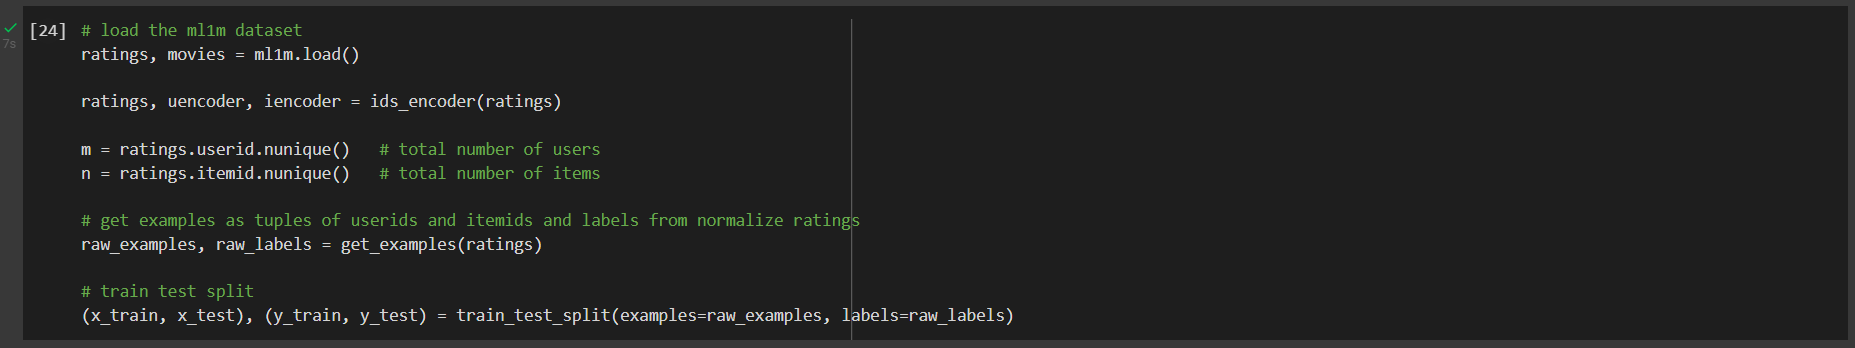

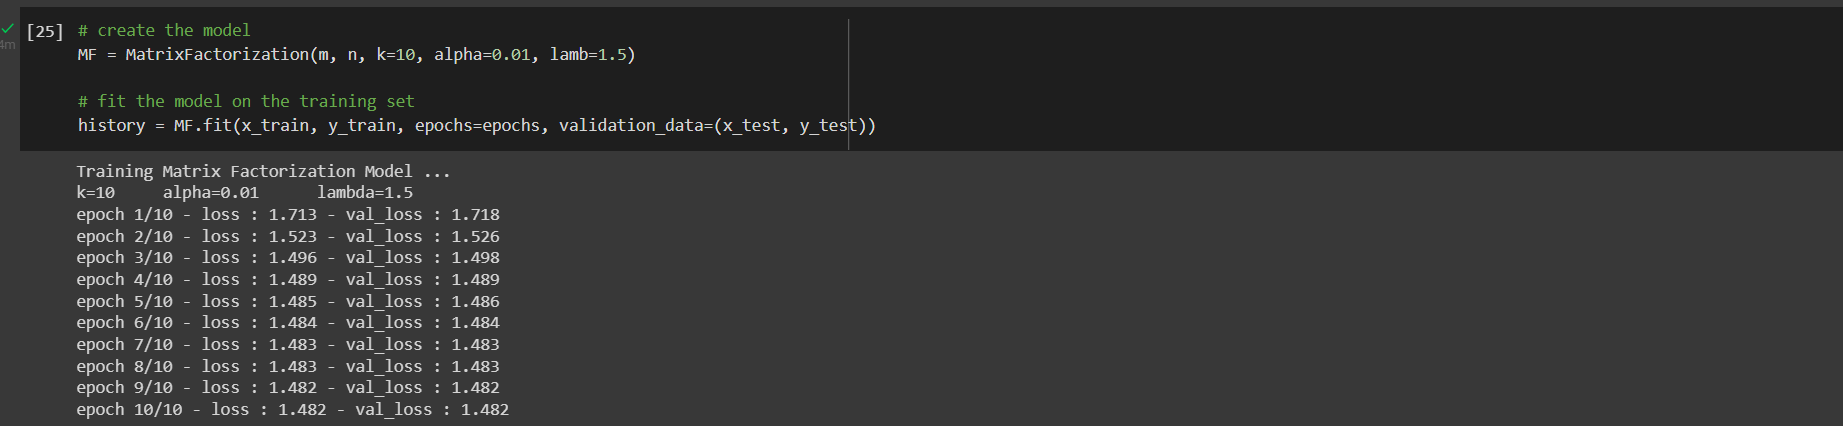

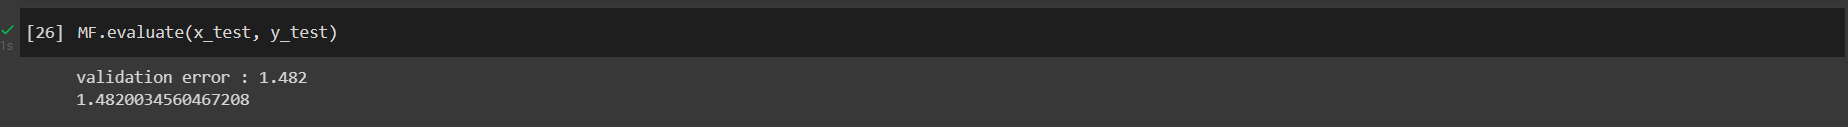

If the validation error is 1.482, it means that on average, the model's predictions are off by 1.482 units.

#### **Evaluation on normalized ratings**

In [ ]:
# create the model
MF = MatrixFactorization(m, n, k=10, alpha=0.01, lamb=1.5)

# fit the model on the training set
history = MF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 0.851 - val_loss : 0.847
epoch 2/10 - loss : 0.831 - val_loss : 0.831
epoch 3/10 - loss : 0.828 - val_loss : 0.829
epoch 4/10 - loss : 0.827 - val_loss : 0.828
epoch 5/10 - loss : 0.827 - val_loss : 0.828
epoch 6/10 - loss : 0.826 - val_loss : 0.828
epoch 7/10 - loss : 0.826 - val_loss : 0.828
epoch 8/10 - loss : 0.826 - val_loss : 0.828
epoch 9/10 - loss : 0.826 - val_loss : 0.828
epoch 10/10 - loss : 0.826 - val_loss : 0.828


In [ ]:
MF.evaluate(x_test, y_test)

validation error : 0.828


0.8276982643684648

If the validation error is 0.825, it means that on average, the model's predictions are off by 0.825 units.

### 3.2.5. Predictions

Now that the latent factors $P$ and $Q$, we can use them to make predictions and recommendations. Let's call the ```predict``` function of the ```Matrix Factorization``` class to make prediction for a given.

rating prediction for user 1 on item 1 for which the truth rating $r=5.0$

In [ ]:
ratings.userid = uencoder.inverse_transform(ratings.userid.to_list())
ratings.itemid = uencoder.inverse_transform(ratings.itemid.to_list())
ratings.head(5)

,userid,itemid,rating,rating_mean,norm_rating
0,1,1,5,4.188679,0.811321
1,1,48,5,4.188679,0.811321
2,1,145,5,4.188679,0.811321
3,1,254,4,4.188679,-0.188679
4,1,514,5,4.188679,0.811321


In [ ]:
4.188679 + MF.predict(userid=1, itemid=1) # add the mean because we have used the normalised ratings for training

4.188679163563357

So, our rating prediction for user 1 on item 1 for which the truth rating $r=5.0$ is 4.2

## Section 3.3: Non-negative Matrix Factorization for Recommendations

Jusl like Matrix Factorization (MF) [(Yehuda Koren et al., 2009)](https://ieeexplore.ieee.org/document/5197422), Non-negative Matrix Factorization (NMF in short) factors the rating matrix $R$ in two matrices in such a way that $R = PQ^{\top}$.

**One limitation of Matrix Factorization**

$P$ and $Q$ values in MF are non interpretable since their components can take arbitrary (positive and negative) values.

**Particulariy of Non-negative Matrix Factorization**

NMF [(Lee and Seung, 1999)](http://www.dm.unibo.it/~simoncin/nmfconverge.pdf) allows the reconstruction of $P$ and $Q$ in such a way that $P,Q \ge 0$. Constraining $P$ and $Q$ values to be taken from $[0,1]$ allows  a probabilistic interpretation

- Latent factors represent groups of users who share the same tastes,
- The value  $P_{u,l}$  represents the probability that user $u$ belongs to the group $l$ of users and 
- The value $Q_{l,i}$ represents the probability that users in the group $l$  likes item $i$.

**Objective function**

With the Euclidian distance, the NMF objective function is defined by

\begin{equation}
J = \frac{1}{2}\sum_{(u,i) \in \kappa}||R_{u,i} - P_uQ_i^{\top}||^2 + \lambda_P||P_u||^2 + \lambda_Q||Q_i||^2
\end{equation}

The goal is to minimize the cost function $J$ by optimizing parameters $P$ and $Q$, with $\lambda_P$ and $\lambda_Q$ the regularizer parameters.

### 3.3.1. First we prepare the tool that we will use it.

Install and import useful packages

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

In [ ]:
from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import ids_encoder
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples
from recsys.preprocessing import scale_ratings

from recsys.datasets import ml1m
from recsys.datasets import ml100k

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

 Load and preprocess rating

In [ ]:
# load data
ratings, movies = ml100k.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# convert ratings from dataframe to numpy array
np_ratings = ratings.to_numpy()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column="rating")

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

### 3.3.2. Non-negative Matrix Factorization Model

In [ ]:
class NMF:
    
    def __init__(self, ratings, m, n, uencoder, iencoder, K=10, lambda_P=0.01, lambda_Q=0.01):
        
        np.random.seed(32)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.ratings = ratings
        self.np_ratings = ratings.to_numpy()
        self.K = K
        self.P = np.random.rand(m, K)
        self.Q = np.random.rand(n, K)
        
        # hyper parameter initialization
        self.lambda_P = lambda_P
        self.lambda_Q = lambda_Q

        # initialize encoders
        self.uencoder = uencoder
        self.iencoder = iencoder
        
        # training history
        self.history = {
            "epochs": [],
            "loss": [],
            "val_loss": [],
        }
    
    def print_training_parameters(self):
        print('Training NMF ...')
        print(f'k={self.K}')
        
    def mae(self, x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training examples
        m = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += abs(r - np.dot(self.P[u], self.Q[i]))
        return error / m
    
    def update_rule(self, u, i, error):
        I = self.np_ratings[self.np_ratings[:, 0] == u][:, [1, 2]]
        U = self.np_ratings[self.np_ratings[:, 1] == i][:, [0, 2]]    
                    
        num = self.P[u] * np.dot(self.Q[I[:, 0]].T, I[:, 1])
        dem = np.dot(self.Q[I[:, 0]].T, np.dot(self.P[u], self.Q[I[:, 0]].T)) + self.lambda_P * len(I) * self.P[u]
        self.P[u] = num / dem

        num = self.Q[i] * np.dot(self.P[U[:, 0]].T, U[:, 1])
        dem = np.dot(self.P[U[:, 0]].T, np.dot(self.P[U[:, 0]], self.Q[i].T)) + self.lambda_Q * len(U) * self.Q[i]
        self.Q[i] = num / dem
    
    @staticmethod
    def print_training_progress(epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0:
            print(f"epoch {epoch}/{epochs} - loss : {round(error, 3)} - val_loss : {round(val_error, 3)}")
                
    def fit(self, x_train, y_train, validation_data, epochs=10):

        self.print_training_parameters()
        x_test, y_test = validation_data
        for epoch in range(1, epochs+1):
            for pair, r in zip(x_train, y_train):
                u, i = pair
                r_hat = np.dot(self.P[u], self.Q[i])
                e = abs(r - r_hat)
                self.update_rule(u, i, e)                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            self.update_history(epoch, error, val_error)
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
    
    def evaluate(self, x_test, y_test):        
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
        print('MAE : ', error)        
        return error
      
    def predict(self, userid, itemid):
        u = self.uencoder.transform([userid])[0]
        i = self.iencoder.transform([itemid])[0]
        r = np.dot(self.P[u], self.Q[i])
        return r

    def recommend(self, userid, N=30):
        # encode the userid
        u = self.uencoder.transform([userid])[0]

        # predictions for users userid on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = self.iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds


### 3.3.3. Train the NMF model with ML-100K dataset

model parameters :

- $k = 10$ : (number of factors)
- $\lambda_P = 0.6$
- $\lambda_Q = 0.6$
- epochs = 10

Note that it may take some time to complete the training on 10 epochs (around 7 minutes).

In [ ]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
nmf = NMF(ratings, m, n, uencoder, iencoder, K=10, lambda_P=0.6, lambda_Q=0.6)
history = nmf.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Training NMF ...
k=10
epoch 1/10 - loss : 0.916 - val_loss : 0.917
epoch 2/10 - loss : 0.915 - val_loss : 0.917
epoch 3/10 - loss : 0.915 - val_loss : 0.917
epoch 4/10 - loss : 0.915 - val_loss : 0.917
epoch 5/10 - loss : 0.915 - val_loss : 0.917
epoch 6/10 - loss : 0.915 - val_loss : 0.917
epoch 7/10 - loss : 0.915 - val_loss : 0.917
epoch 8/10 - loss : 0.915 - val_loss : 0.917
epoch 9/10 - loss : 0.915 - val_loss : 0.917
epoch 10/10 - loss : 0.915 - val_loss : 0.917


In [ ]:
nmf.evaluate(x_test, y_test)

validation error : 0.917
MAE :  0.9165041343019539


0.9165041343019539

If the validation error is 0.917, it means that on average, the model's predictions are off by 0.917 units.

### 3.3.4. Evaluation of NMF with Scikit-suprise

We can use the [scikt-suprise](https://surprise.readthedocs.io/en/stable/) package to train the NMF model. It  is an easy-to-use Python scikit for recommender systems.

1. Import the NMF class from the suprise scikit.
2. Load the data with the built-in function
3. Instanciate NMF with ```k=10``` (```n_factors```) and we use 10 epochs (```n_epochs```)
4. Evaluate the model using cross-validation with 5 folds.

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626504 sha256=230ddf5c84c5a5c3d4b7d4f9d1c141b5d50659a9e6ec11c914f7b185b105134f
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
from surprise import NMF
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the NMF algorithm.
nmf = NMF(n_factors=10, n_epochs=10)

# Run 5-fold cross-validation and print results.
history = cross_validate(nmf, data, measures=['MAE'], cv=5, verbose=True)

Evaluating MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9584  0.9640  0.9456  0.9566  0.9481  0.9545  0.0068  
Fit time          0.50    0.48    0.49    0.49    0.50    0.49    0.01    
Test time         0.34    0.24    0.23    0.15    0.23    0.24    0.06    


As result, the mean MAE on the test set in Folder 5 is **MAE = 0.9481** which is equivalent to the result we have obtained on *ml-100k* with our own implementation **mae = 0.9165**

#### **ML-1M**


In [ ]:
data = Dataset.load_builtin('ml-1m')
nmf = NMF(n_factors=10, n_epochs=10)
history = cross_validate(nmf, data, measures=['MAE'], cv=5, verbose=True)

Dataset ml-1m could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m
Evaluating MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.9553  0.9546  0.9598  0.9582  0.9546  0.9565  0.0021  
Fit time          3.88    4.13    4.40    4.26    4.36    4.21    0.19    
Test time         2.61    2.39    2.84    2.13    2.73    2.54    0.25    


The mean MAE on a 5-fold cross-validation is **MAE = 0.9546**


## Section 3.4: Explainable Matrix Factorization (EMF)

How to quantify explainability ?

- Use the rating distribution within the active user’s neighborhood. 
- If many neighbors have rated the recommended item, then this can provide a basis upon which to explain the recommendations, using neighborhood style explanation mechanisms

By including explainability weight in the training algorithm, the new objective function, to be minimized over the set of known ratings, has been formulated by [(Abdollahi and Nasraoui, 2016)](https://www.researchgate.net/publication/301616080_Explainable_Matrix_Factorization_for_Collaborative_Filtering) as:

\begin{equation}
 J = \sum_{(u,i)\in \kappa} (R_{ui} - \hat{R}_{ui})^2 +\frac{\beta}{2}(||P_u||^2 + ||Q_i||^2) + \frac{\lambda}{2}(P_u-Q_i)^2W_{ui},
\end{equation}

here, $\frac{\beta}{2}(||P_u||^2 + ||Q_i||^2)$ is the $L_2$ regularization term weighted by the coefficient $\beta$, and $\lambda$ is an explainability regularization coefficient that controls the smoothness of the new representation and tradeoff between explainability and accuracy. The idea here is that if item $i$ is explainable for user $u$, then their representations in the latent space, $Q_i$ and $P_u$, should be close to each other. Stochastic Gradient descent can be used to optimize the objectve function.

\begin{equation}
P_u \leftarrow P_u + \alpha\left(2(R_{u,i}-P_uQ_i^{\top})Q_i - \beta P_u - \lambda(P_u-Q_i)W_{ui}\right)
\end{equation}
\begin{equation}
Q_i \leftarrow Q_i + \alpha\left(2(R_{u,i}-P_uQ_i^{\top})P_u - \beta Q_i + \lambda(P_u-Q_i)W_{ui}\right)
\end{equation}

### 3.4.1. First we prepare the tool that we will use it.

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

In [ ]:
from recsys.memories.UserToUser import UserToUser

from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import ids_encoder
from recsys.preprocessing import train_test_split
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples

from recsys.datasets import ml100k, ml1m

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
import os

### 3.4.2. Compute Explainable Scores

Explainable score are computed using neighborhood based similarities. Here, we are using the user based algorithme to compute similarities.

In [ ]:
def explainable_score(user2user, users, items, theta=0):
    
    def _progress(count):
        sys.stdout.write('\rCompute Explainable score. Progress status : %.1f%%'%(float(count/len(users))*100.0))
        sys.stdout.flush()
    # initialize explainable score to zeros
    W = np.zeros((len(users), len(items)))

    for count, u in enumerate(users):            
        candidate_items = user2user.find_user_candidate_items(u)        
        for i in candidate_items:                
            user_who_rated_i, similar_user_who_rated_i = \
                user2user.similar_users_who_rated_this_item(u, i)
            if user_who_rated_i.shape[0] == 0:
                w = 0.0
            else:
                w = similar_user_who_rated_i.shape[0] / user_who_rated_i.shape[0]
            W[u,i] =  w  if w > theta else 0.0
        _progress(count)
    return W

### 3.4.3. Explainable Matrix Factorization Model

In [ ]:
class ExplainableMatrixFactorization:
    
    def __init__(self, m, n, W, alpha=0.001, beta=0.01, lamb=0.1, k=10):
        """
            - R : Rating matrix of shape (m,n) 
            - W : Explainability Weights of shape (m,n)
            - k : number of latent factors
            - beta : L2 regularization parameter
            - lamb : explainability regularization coefficient
            - theta : threshold above which an item is explainable for a user
        """
        self.W = W
        self.m = m
        self.n = n
        
        np.random.seed(64)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.k = k
        self.P = np.random.normal(size=(self.m,k))
        self.Q = np.random.normal(size=(self.n,k))
        
        # hyperparameter initialization
        self.alpha = alpha
        self.beta = beta
        self.lamb = lamb
        
        # training history
        self.history = {
            "epochs":[],
            "loss":[],
            "val_loss":[],
        }
        
    def print_training_parameters(self):
        print('Training EMF')
        print(f'k={self.k} \t alpha={self.alpha} \t beta={self.beta} \t lambda={self.lamb}')
        
    def update_rule(self, u, i, error):
        self.P[u] = self.P[u] + \
            self.alpha*(2 * error*self.Q[i] - self.beta*self.P[u] - self.lamb*(self.P[u] - self.Q[i]) * self.W[u,i])
        
        self.Q[i] = self.Q[i] + \
            self.alpha*(2 * error*self.P[u] - self.beta*self.Q[i] + self.lamb*(self.P[u] - self.Q[i]) * self.W[u,i])
        
    def mae(self,  x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training exemples
        M = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += np.absolute(r - np.dot(self.P[u], self.Q[i]))
        return error/M
    
    def print_training_progress(self, epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0 :
                print(f"epoch {epoch}/{epochs} - loss : {round(error,3)} - val_loss : {round(val_error,3)}")
                
    def learning_rate_schedule(self, epoch, target_epochs = 20):
        if (epoch >= target_epochs) and (epoch % target_epochs == 0):
                factor = epoch // target_epochs
                self.alpha = self.alpha * (1 / (factor * 20))
                print("\nLearning Rate : {}\n".format(self.alpha))
        
    def fit(self, x_train, y_train, validation_data, epochs=10):
        """
        Train latent factors P and Q according to the training set
        
        :param
            - x_train : training pairs (u,i) for which rating r_ui is known
            - y_train : set of ratings r_ui for all training pairs (u,i)
            - validation_data : tuple (x_test, y_test)
            - epochs : number of time to loop over the entire training set. 
            10 epochs by default
            
        Note that u and i are encoded values of userid and itemid
        """
        self.print_training_parameters()
        
        # get validation data
        x_test, y_test = validation_data
        
        for epoch in range(1, epochs+1):
            for pair, r in zip(x_train, y_train):                
                u,i = pair                
                r_hat = np.dot(self.P[u], self.Q[i])                
                e = r - r_hat
                self.update_rule(u, i, error=e)
                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            self.update_history(epoch, error, val_error)            
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
    
    def evaluate(self, x_test, y_test):
        """
        compute the global error on the test set
        
        :param
            - x_test : test pairs (u,i) for which rating r_ui is known
            - y_test : set of ratings r_ui for all test pairs (u,i)
        """
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
      
    def predict(self, userid, itemid):
        """
        Make rating prediction for a user on an item

        :param
        - userid
        - itemid

        :return
        - r : predicted rating
        """
        # encode user and item ids to be able to access their latent factors in
        # matrices P and Q
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]

        # rating prediction using encoded ids. Dot product between P_u and Q_i
        r = np.dot(self.P[u], self.Q[i])

        return r

    def recommend(self, userid, N=30):
        """
        make to N recommendations for a given user

        :return 
        - (top_items,preds) : top N items with the highest predictions 
        """
        # encode the userid
        u = uencoder.transform([userid])[0]

        # predictions for this user on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds

In [ ]:
epochs = 10

### 3.4.4. Model Evaluation

#### MovieLens 100K

##### **Evaluation on raw data**

In [ ]:
# load data
ratings, movies = ml100k.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# compute explainable score
W = explainable_score(usertouser, users, items)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute Explainable score. Progress status : 99.9%

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.922 - val_loss : 1.036
epoch 2/10 - loss : 0.79 - val_loss : 0.873
epoch 3/10 - loss : 0.766 - val_loss : 0.837
epoch 4/10 - loss : 0.757 - val_loss : 0.822
epoch 5/10 - loss : 0.753 - val_loss : 0.814
epoch 6/10 - loss : 0.751 - val_loss : 0.808
epoch 7/10 - loss : 0.749 - val_loss : 0.805
epoch 8/10 - loss : 0.748 - val_loss : 0.802
epoch 9/10 - loss : 0.746 - val_loss : 0.799
epoch 10/10 - loss : 0.745 - val_loss : 0.797


In [ ]:
EMF.evaluate(x_test, y_test)

validation error : 0.797


If the validation error is 0.797, it means that on average, the model's predictions are off by 0.797 units.

##### **Evaluation on normalized data**

In [ ]:
# load data
ratings, movies = ml100k.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.022, beta=0.65, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.022 	 beta=0.65 	 lambda=0.01
epoch 1/10 - loss : 0.809 - val_loss : 0.842
epoch 2/10 - loss : 0.809 - val_loss : 0.829
epoch 3/10 - loss : 0.807 - val_loss : 0.821
epoch 4/10 - loss : 0.799 - val_loss : 0.811
epoch 5/10 - loss : 0.789 - val_loss : 0.8
epoch 6/10 - loss : 0.782 - val_loss : 0.793
epoch 7/10 - loss : 0.778 - val_loss : 0.789
epoch 8/10 - loss : 0.776 - val_loss : 0.786
epoch 9/10 - loss : 0.774 - val_loss : 0.784
epoch 10/10 - loss : 0.773 - val_loss : 0.783


#### MovieLens 1M

##### **Evaluation on raw data**

In [ ]:
# load data
ratings, movies = ml1m.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# compute explainable score
W = explainable_score(usertouser, users, items)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute Explainable score. Progress status : 100.0%

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.782 - val_loss : 0.807
epoch 2/10 - loss : 0.762 - val_loss : 0.781
epoch 3/10 - loss : 0.76 - val_loss : 0.775
epoch 4/10 - loss : 0.758 - val_loss : 0.771
epoch 5/10 - loss : 0.757 - val_loss : 0.769
epoch 6/10 - loss : 0.756 - val_loss : 0.767
epoch 7/10 - loss : 0.754 - val_loss : 0.764
epoch 8/10 - loss : 0.752 - val_loss : 0.762
epoch 9/10 - loss : 0.751 - val_loss : 0.761
epoch 10/10 - loss : 0.75 - val_loss : 0.76


##### **Evaluation on normalized data**

In [ ]:
# load data
ratings, movies = ml1m.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [ ]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.023, beta=0.59, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.023 	 beta=0.59 	 lambda=0.01
epoch 1/10 - loss : 0.805 - val_loss : 0.814
epoch 2/10 - loss : 0.764 - val_loss : 0.77
epoch 3/10 - loss : 0.756 - val_loss : 0.762
epoch 4/10 - loss : 0.755 - val_loss : 0.759
epoch 5/10 - loss : 0.754 - val_loss : 0.759
epoch 6/10 - loss : 0.754 - val_loss : 0.758
epoch 7/10 - loss : 0.754 - val_loss : 0.758
epoch 8/10 - loss : 0.753 - val_loss : 0.758
epoch 9/10 - loss : 0.753 - val_loss : 0.758
epoch 10/10 - loss : 0.753 - val_loss : 0.758


#### Ratings prediction

In [ ]:
# get list of top N items with their corresponding predicted ratings
userid = 42
recommended_items, predictions = EMF.recommend(userid=userid)

# find corresponding movie titles
top_N = list(zip(recommended_items,predictions))
top_N = pd.DataFrame(top_N, columns=['itemid','predictions'])
top_N.predictions = top_N.predictions + ratings.loc[ratings.userid==userid].rating_mean.values[0]
List = pd.merge(top_N, movies, on='itemid', how='inner')

# show the list
List

,itemid,predictions,title,genres
0,3460,4.364036,Hillbillys in a Haunted House (1967),Comedy
1,701,4.324177,Daens (1992),Drama
2,3057,4.307404,Where's Marlowe? (1999),Comedy
3,2214,4.304979,Number Seventeen (1932),Thriller
4,1145,4.299559,Snowriders (1996),Documentary
5,2258,4.292125,Master Ninja I (1984),Action
6,3353,4.281912,"Closer You Get, The (2000)",Comedy|Romance
7,868,4.278937,Death in Brunswick (1991),Comedy
8,826,4.269901,Diebinnen (1995),Drama
9,3305,4.266769,Bluebeard (1944),Film-Noir|Horror


**Note**: The recommendation list may content items already purchased by the user. This is just an illustration of how to implement matrix factorization recommender system.